# Exploratory Analysis on AlienVault

In [143]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"



# Change log
## v.2.5
- Feature Extraction
    - Six new features: Total references, total indicators, total tags, total malware families per pulse, creation year and month

## v.2.2
- Now all functions are used to load only .pkl files and DO NOT work properly from new-fetched pulses from the API 
    - To fetch new pulses we will use the get_subscriptions_job.py file
- Load .pkl (pickle) files instead of .csv (as the fetched data are now saved in .pkl file instead of .csv
    - This solves the problem with the nested json in the indicators attribute (quotation marks, were saved in wrong format in .csv file)
- Include all the analysis of the pulses under a single function (so far a single function were used only in indicators) 
- Empty strings --> "" & empty lists --> [] are replaced with NaN values
    - Functions were modified accordingly
- New metrics; fraction of missing values per column
    



## v2.1
- Load local files (fetched dataset from the API)
- Perform the analysis on the pulses of the Alienvault profile (2680 pulses; https://otx.alienvault.com/user/AlienVault/pulses)


## API Key Configuration

In [144]:
from OTXv2 import OTXv2, IndicatorTypes #AlienVault's script files  - https://github.com/AlienVault-OTX/OTX-Python-SDK

In [202]:
import matplotlib.pyplot as plt 
import seaborn as sns
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['figure.dpi'] = 300


import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 800)
pd.set_option('display.max_rows', 100)

import os
#get filesize
suffixes = ['B', 'KB', 'MB', 'GB', 'TB', 'PB'] #https://stackoverflow.com/a/14996816/13030358 #convert to mb
def humansize(nbytes):
    i = 0
    while nbytes >= 1024 and i < len(suffixes)-1:
        nbytes /= 1024.
        i += 1
    f = ('%.2f' % nbytes).rstrip('0').rstrip('.')
    return '%s %s' % (f, suffixes[i])

#humansize(os.stat('/project/OTX-Python-SDK/fetched_data/pulses_set_METADEFENDER.csv').st_size )

import numpy as np

import json

In [203]:
 #pd.show_versions(as_json=False)

In [204]:
from datetime import datetime, timedelta

## Subscriptions

The getall() method accesses your subscriptions.  It downloads all the OTX pulses and their assocciated indicators of compromise (IOCs) from your account. This includes:  
- All pulses you subscribe to directly
- All pulses by users you subscribe to
- OTX pulses you created (including private pulses)
If this is the first time you are using your account, the download includes all pulses created by AlienVault. All users are subscribed to the AlienVault user by default.

In [205]:
# pulses = otx.getall()
# pulses_df = pd.json_normalize(pulses)
# pulses_df['created'] = pd.to_datetime(pulses_df.created)
# pulses_df['modified'] = pd.to_datetime(pulses_df.modified)
# pulses_df.shape
# pulses_df.head()

### Save dataset for further analysis (optional)
#pulses_df.to_csv('./fetched_data/pulses_set_' + ver + '.csv')

####
#OR#
####
pulses_df = pd.read_pickle('/project/OTX-Python-SDK/fetched_data/ALIENVAULT_pulses_set.pkl')
pulses_df['created'] = pd.to_datetime(pulses_df.created)
pulses_df['modified'] = pd.to_datetime(pulses_df.modified)

#sample if we want quick loading of subset
#pulses_df = pulses_df.sample(5000, random_state=94)


In [206]:
pulses_df.shape

(2670, 19)

In [207]:
pulses_df.iloc[1,12:].to_frame().T

,indicators,attack_ids,more_indicators,revision,adversary,id,name
1,"[{'indicator': 'datacoup.com', 'description': '', 'title': '', 'created': '2020-06-01T14:35:26', 'is_active': 1, 'content': '', 'expiration': None, 'type': 'domain', 'id': 2260344996}, {'indicator': 'consumerspost.xyz', 'description': '', 'title': '', 'created': '2020-06-01T14:35:26', 'is_active': 1, 'content': '', 'expiration': None, 'type': 'domain', 'id': 2260344997}, {'indicator': 'documentsharing.space', 'description': '', 'title': '', 'created': '2020-06-01T14:35:26', 'is_active': 1, 'content': '', 'expiration': None, 'type': 'domain', 'id': 2260344998}, {'indicator': 'centeralfiles.xyz', 'description': '', 'title': '', 'created': '2020-06-01T14:35:26', 'is_active': 1, 'content': '', 'expiration': None, 'type': 'domain', 'id': 2260344999}, {'indicator': 'theashyggdrasil.xyz', 'de...","[T1059, T1060, T1064, T1083, T1113, T1127]",False,1,,5ed5122d4b46071c940688ab,New RAT in Macro-Based Docs Using AppLocker Bypass


## Preprocessing I

In [208]:
#Convert empty to NaNs
#pulses_df = pulses_df.replace("", np.nan)  #replace empty strings with NaN


## Feature Extraction

In [209]:
pulses_df['total_ref'] = pulses_df.references.apply(lambda x: len(x))
pulses_df['total_ind'] = pulses_df.indicators.apply(lambda x: len(x))
pulses_df['total_tags'] = pulses_df.tags.apply(lambda x: len(x))
pulses_df['total_mal_fam'] = pulses_df.malware_families.apply(lambda x: len(x))
pulses_df['year'] = pulses_df.created.dt.year
pulses_df['month'] = pulses_df.created.dt.month

## Preprocessing II

In [210]:
#pulses_df = pulses_df.mask(pulses_df.applymap(str).eq('[]')) #replace empty lists with NaN

## Fraction of Nulls to total per attribute

In [211]:
missing = pd.Series(pulses_df.isnull().mean() * 100).to_frame().round(2).T
missing.index = ['Missing (%):']
missing

,industries,tlp,description,created,tags,malware_families,modified,author_name,public,extract_source,references,targeted_countries,indicators,attack_ids,more_indicators,revision,adversary,id,name,total_ref,total_ind,total_tags,total_mal_fam,year,month
Missing (%):,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Fix Indicators column

In [212]:
#pulses_df['indicators'] = pulses_df['indicators'].fillna('[]')

## Extract Indicators

In [213]:
# #Indicators
# full_iocs_export = pd.DataFrame(columns=['indicator', 'description', 'title', 'created', 'is_active', 'content',
#            'expiration', 'type', 'id', 'pulse_name', 'pulse_id'])

# for uid in range(0, pulses_df.shape[0]):
#     uid_pulses = pulses_df['indicators'][uid]
#     uid_pulses = pd.json_normalize(uid_pulses)
#     uid_pulses['pulse_name'] = pulses_df['name'][uid]
#     uid_pulses['pulse_id'] = pulses_df['id'][uid]
#     full_iocs_export = full_iocs_export.append(uid_pulses)
    
# #full_iocs_export.to_csv('./fetched_data/full_iocs_set_v2.csv')  '''

## Explanation of Pulses' Attributes

In [214]:
pulses_df.head()

,industries,tlp,description,created,tags,malware_families,modified,author_name,public,extract_source,references,targeted_countries,indicators,attack_ids,more_indicators,revision,adversary,id,name,total_ref,total_ind,total_tags,total_mal_fam,year,month
0,[],white,"After a few months of inactivity, it looks like TA505 is back. New campaign targeting german users.",2020-06-02 16:07:07.756,"[malware, TA505]",[],2020-06-02 16:59:16.100,AlienVault,1,[],[],[Germany],"[{'indicator': 'reselling-corp.com', 'description': '', 'title': '', 'created': '2020-06-02T16:59:16', 'is_active': 1, 'content': '', 'expiration': None, 'type': 'domain', 'id': 2195417767}, {'indicator': 'corp-storage.com', 'description': '', 'title': '', 'created': '2020-06-02T16:07:09', 'is_active': 1, 'content': '', 'expiration': None, 'type': 'domain', 'id': 2263044909}, {'indicator': '61c213351ae315f40735e34d9f8ac0613506c664b48dd7dadb2e42d71cfeb978', 'description': '', 'title': '', 'created': '2020-06-02T16:07:09', 'is_active': 1, 'content': '', 'expiration': None, 'type': 'FileHash-SHA256', 'id': 2263044910}, {'indicator': '3aaec0f505047aac22032c3828999a60b2e3780422c514a6c27a815bc5e7eb3a', 'description': '', 'title': '', 'created': '2020-06-02T16:07:09', 'is_active': 1, 'content...",[],False,2,TA505,5ed6792bbc276d41051ed969,TA505 June 2020 Campaign,0,17,2,0,2020,6
1,[Technology],white,"In February 2020 and May 2020, Zscaler observed four malicious macro-based Microsoft Word documents hosted on newly registered sites with top-level domains of .space and .xyz. We attribute these attacks to the same threat actor due to the similar tactics, techniques and procedures (TTPs) used to deploy the final payload.\n\nThe final .NET payload, to the best of our knowledge, has not been observed in the wild before. It has a small code section in it that overlaps with the QuasarRAT. However, this code was not used at runtime. We have assigned the name - ShellReset to this RAT based on the unique strings found inside the final payload.",2020-06-01 14:35:25.141,"[QuasarRAT, ShellReset RAT]","[ShellReset RAT, QuasarRAT - S0262]",2020-06-01 14:35:25.141,AlienVault,1,[],[https://www.zscaler.com/blogs/research/shellreset-rat-spread-through-macro-based-documents-using-applocker-bypass],[],"[{'indicator': 'datacoup.com', 'description': '', 'title': '', 'created': '2020-06-01T14:35:26', 'is_active': 1, 'content': '', 'expiration': None, 'type': 'domain', 'id': 2260344996}, {'indicator': 'consumerspost.xyz', 'description': '', 'title': '', 'created': '2020-06-01T14:35:26', 'is_active': 1, 'content': '', 'expiration': None, 'type': 'domain', 'id': 2260344997}, {'indicator': 'documentsharing.space', 'description': '', 'title': '', 'created': '2020-06-01T14:35:26', 'is_active': 1, 'content': '', 'expiration': None, 'type': 'domain', 'id': 2260344998}, {'indicator': 'centeralfiles.xyz', 'description': '', 'title': '', 'created': '2020-06-01T14:35:26', 'is_active': 1, 'content': '', 'expiration': None, 'type': 'domain', 'id': 2260344999}, {'indicator': 'theashyggdrasil.xyz', 'de...","[T1059, T1060, T1064, T1083, T1113, T1127]",False,1,,5ed5122d4b46071c940688ab,New RAT in Macro-Based Docs Using AppLocker Bypass,1,26,2,2,2020,6
2,[],white,During Cyber Defense monitoring activities Yori intercepted waves of incoming emails directed to many companies. These messages were leveraging FMLA (Family and Medical Leave Act) requests related to the ongoing COVID-19 pandemic. These emails were weaponized with two versatile cyber-criminal tools: Himera and Absent-Loader.,2020-05-29 15:58:40.917,"[COVID-19, Himera, AbSent-Loader]","[AbSent-Loader, Himera]",2020-05-29 18:19:50.268,AlienVault,1,[],[https://yoroi.company/research/himera-and-absent-loader-leverage-covid19-themes/],[],"[{'indicator': '501ac08ebac646517b00d3234dfe58837b460bd5f045822d9fb5999f00979bfe', 'description': 'SHA256 of 97fa1f66bd2b2f8a34aafe5a374996f8', 'title': '#Exploit:Win32/CVE-2014-6352.A!lofi', 'created': '2020-05-29T15:58:42', 'is_act

> Description of the attributes is a mix of documentantion and personal research (labelled as [P], if no information then empty)


- industries [P]: 
- tlp [P]: Traffic Light Protocol;  is a set of designations used to ensure that sensitive information is shared with the appropriate audience. For further info visit: https://www.us-cert.gov/tlp
- description : Describes the pulse in terms of the type of threat it poses, and any other facts that may link it to other threat indicators.
- created: Date when the pulse was created in the system
- tags: List of tags that provide information about pulse content, for example, Phshing, malware, C&C, and apt.
- malware_families [P]: 
- modified: Date when the pulse was last modified
- author_name: The username of the OTX User that created the pulse
- public [P]: 
- extract_source [P]: 
- references: List of references to papers, websites or blogs related to the threat described in the pulse
- targeted_countries [P]: 
- indicators: Collection of Indicators Of Compromise. This attribute will be explored extensively in the next part of our analysis
- attack_ids [P]: 
- more_indicators [P]: 
- revision: Revision number that increments each time pulse contents change
- adversary [P]: 
- id: Unique identifier of the pulse
- name: Name of the pulse



### Attributes - Summary Statistics of Pulses
Below we show attributes or calculate/visualize summary statistics out of all pulses

In [215]:
from IPython.core import display as ICD #ref: https://stackoverflow.com/a/36721331/13030358

def pulses_exploration(pulses_DF):
    all_industries = []

    for pid , row in enumerate(pulses_DF):
        if isinstance(pulses_DF.industries[pid], float) == True:  #if the element is float --> Nan if the element is list then it has values
            continue
        industries = pulses_DF.industries[pid]
        all_industries.extend(industries)

    all_industries = pd.Series(all_industries)
    print("Labelled Industries count:\n")
    print(all_industries.value_counts())
    
    
    print('A sneak peek of descriptions:')
    descriptions = pulses_DF.description.replace('', np.nan)
    descriptions = descriptions.dropna().to_frame()
    pd.set_option('max_colwidth', None) #temporary show full text - open
    ICD.display(descriptions)
    pd.set_option('max_colwidth', 50) #temporary show full text - close
    
    #Extract all tags from all pulses, create aggregations
    #!# Needs further improvement; standardize tags (e.g COVID-19 ,covid-19 , covid )
    all_tags = []

    for pid , row in enumerate(pulses_DF):
        if  isinstance(pulses_DF.tags[pid], float) == True: #if the element is float --> Nan if the element is list then it has values
            continue
        tags = pulses_DF.tags[pid]
        all_tags.extend(tags)

    all_tags = pd.Series(all_tags)
    print('Tags found:')
    print(all_tags.value_counts())
    

    ttag = pulses_DF.total_tags.value_counts().sort_index()
    print('Number of Pulses for different number of tags (index)')
    print(ttag)
    print('Cumulative Percentage of Pulses for different number of tags')
    print(ttag.cumsum()/ ttag.sum())
    
    
    #Extract all malware families from all pulses, create aggregations
    all_malware_families = []

    for pid , row in enumerate(pulses_DF):
        if isinstance(pulses_DF.malware_families[pid], float) == True:   #if the element is float --> Nan if the element is list then it has values
            continue
        malware_families = pulses_DF.malware_families[pid]
        all_malware_families.extend(malware_families)

    all_malware_families = pd.Series(all_malware_families).replace('', np.nan).dropna()
    print('\n Malware families:')
    print(all_malware_families.value_counts())
    

    tmalfam = pulses_DF.total_mal_fam.value_counts().sort_index()
    print('Number of Pulses for different number of malware families(index)')
    print(tmalfam)
    print('Cumulative Percentage of Pulses for different number of malware families')
    print(tmalfam.cumsum()/ tmalfam.sum())

    

    #Number of pulses per author 
    print('\n Number of pulses per author:')
    print(pulses_DF.author_name.value_counts())

    #Public
    print('\n Number of public pulses:')
    print(pulses_DF.public.value_counts())
    
    
    #Extract all targeted countries from all pulses, create aggregations
    #Note that pulses may not indicate a specific targeted country
    all_targeted_countries = []

    for pid , row in enumerate(pulses_DF):
        if isinstance(pulses_DF.targeted_countries[pid], float) == True:  #if the element is float --> Nan if the element is list then it has values
            continue
        targeted_countries = pulses_DF.targeted_countries[pid]
        all_targeted_countries.extend(targeted_countries)

    all_targeted_countries = pd.Series(all_targeted_countries)
    
    print('\n Targeted countries:')
    print(all_targeted_countries.value_counts())
    
    
    #Extract all attack_ids from all pulses, create aggregations
    #Note that pulses may not indicate a specific attack id
    all_attack_ids = []

    for pid , row in enumerate(pulses_DF):
        if isinstance(pulses_DF.attack_ids[pid], float) == True:  #if the element is float --> Nan if the element is list then it has values
            continue
        attack_ids = pulses_DF.attack_ids[pid]
        all_attack_ids.extend(attack_ids)

    all_attack_ids = pd.Series(all_attack_ids).replace('', np.nan).dropna()
    
    print('\n Attack IDs count:')
    print(all_attack_ids.value_counts())
    
    #More indicators value counts
    print('More indicators label:')
    print(pulses_DF.more_indicators.value_counts())
    
    tind = pulses_DF.total_ind.value_counts().sort_index()
    print('Number of Pulses for different number of indicators (index)')
    print(tind)
    print('Cumulative Percentage of Pulses for different number of indicitarors')
    print(tind.cumsum()/ tind.sum())

    
    #Revisions
    print('\n Revision of pulses (counts how many pulses had total revisions)')
    print(pulses_DF.revision.value_counts())
    
    #References
    tref = pulses_DF.total_ref.value_counts().sort_index()
    print('Number of Pulses for different number of references (index)')
    print(tref)
    print('Cumulative Percentage of Pulses for different number of references')
    print(tref.cumsum()/ tref.sum())

    
    #Adversaries
    
    #Adversaries
    total_adversaries = pulses_DF.adversary.value_counts().to_frame().reset_index()
    total_adversaries = total_adversaries.replace('', np.nan).dropna().set_index('index')
    total_adversaries = pd.Series(total_adversaries['adversary'])
    
    print('\n Total adversaries out of all pulses ')   #!!!!!!!!!!! IT SEEMS AN INTERESTING LABEL
    print(total_adversaries)
    
    
    print('\n Names of Pulses')
    #get the name of the pulses
    names = pulses_df.name.to_frame()
    pd.set_option('max_colwidth', None) #temporary show full text - open
    ICD.display(names)
    pd.set_option('max_colwidth', 50) #temporary show full text - close

    
    #TLP
    sns.countplot(x="tlp", data=pulses_DF).set_title('Total Pulses per TLP count'); 
    plt.subplots() 

    #Cumulative Pulses per day
    temp = pulses_DF.groupby('created').id.count()
    temp = temp.groupby(temp.index).cumsum().reset_index()
    temp['cumsum_pulses'] = temp.id.cumsum()
    temp = temp.set_index('created')
    temp.cumsum_pulses.plot(title='Cumulative number of pulses per day');


Labelled Industries count:

Government        3
Finance           2
Manufacturing     1
Transportation    1
Technology        1
govenrment        1
                  1
dtype: int64
A sneak peek of descriptions:


,description
0,"After a few months of inactivity, it looks like TA505 is back. New campaign targeting german users."
1,"In February 2020 and May 2020, Zscaler observed four malicious macro-based Microsoft Word documents hosted on newly registered sites with top-level domains of .space and .xyz. We attribute these attacks to the same threat actor due to the similar tactics, techniques and procedures (TTPs) used to deploy the final payload.\n\nThe final .NET payload, to the best of our knowledge, has not been observed in the wild before. It has a small code section in it that overlaps with the QuasarRAT. However, this code was not used at runtime. We have assigned the name - ShellReset to this RAT based on the unique strings found inside the final payload."
2,During Cyber Defense monitoring activities Yori intercepted waves of incoming emails directed to many companies. These messages were leveraging FMLA (Family and Medical Leave Act) requests related to the ongoing COVID-19 pandemic. These emails were weaponized with two versatile cyber-criminal tools: Himera and Absent-Loader.
3,"Newly identified Turla activity based around the Kazuar trojan, branded to appear as sysinternals. See reference for full details."
4,Suspicous lure used by the DPRK Konni APT. See reference for source.
...,...
2638,"Casinos and resort hotels are the most recent victims of an attack that used RawPOS, an old POS malware, to steal customer data. The victims include establishments in the United States, Canada, Europe, Middle East, and Latin America."
2639,Enterprises are currently being targeted by the macro malware BARTALEX in a recent outbreak of thousands of spammed emails. The infection routine for BARTALEX uses a Microsoft Word document and social engineering lure that is widely recognized by enterprises—making infection all too possible. This attack highlights how macro malware in Microsoft Office files is fast becoming a big threat to businesses and organizations.
2640,"As spotted by FireEye on 2015-04-17, Angler EK is now taking advantage of a vulnerability patched with the last version of Flash Player ( 17.0.0.169 )"
2641,"A one-man cybercriminal operation that uses pointof-sale\n(PoS) malware has stolen more than 22,000\nunique credit card numbers from terminals in Brazil,\nCanada, and the United States in a span of just one\nmonth."


Tags found:
APT                     3
malware                 2
COVID-19                2
Aggah                   2
Russia                  2
netwalker               1
Double Guns             1
alien labs              1
ShellReset RAT          1
covid-19                1
AbSent-Loader           1
TA505                   1
Turla                   1
Cassowary               1
octopus scanner         1
win64/turla.ap          1
win32/turla.e           1
zoom                    1
Dropper                 1
Monero                  1
github                  1
linux                   1
agenttesla              1
okrum                   1
Brazil                  1
Iran                    1
Trickbot                1
ke3chang                1
Sandworm                1
android                 1
netbeans                1
Calypso                 1
allatori                1
Signed Malware          1
comrat                  1
macos                   1
powershell              1
ShuangQiang             1


,name
0,TA505 June 2020 Campaign
1,New RAT in Macro-Based Docs Using AppLocker Bypass
2,Himera and AbSent-Loader Leverage COVID-19 Themes
3,SysInTURLA - Newer Kazuar samples
4,Konni APT CISAC Lure
...,...
2665,Xhamster victim of large malvertising campaign
2666,Malware spam: mereway kitchen
2667,Adobe Flash 0day - CVE-2015-0313
2668,Flash 0day CVE-2015-0313


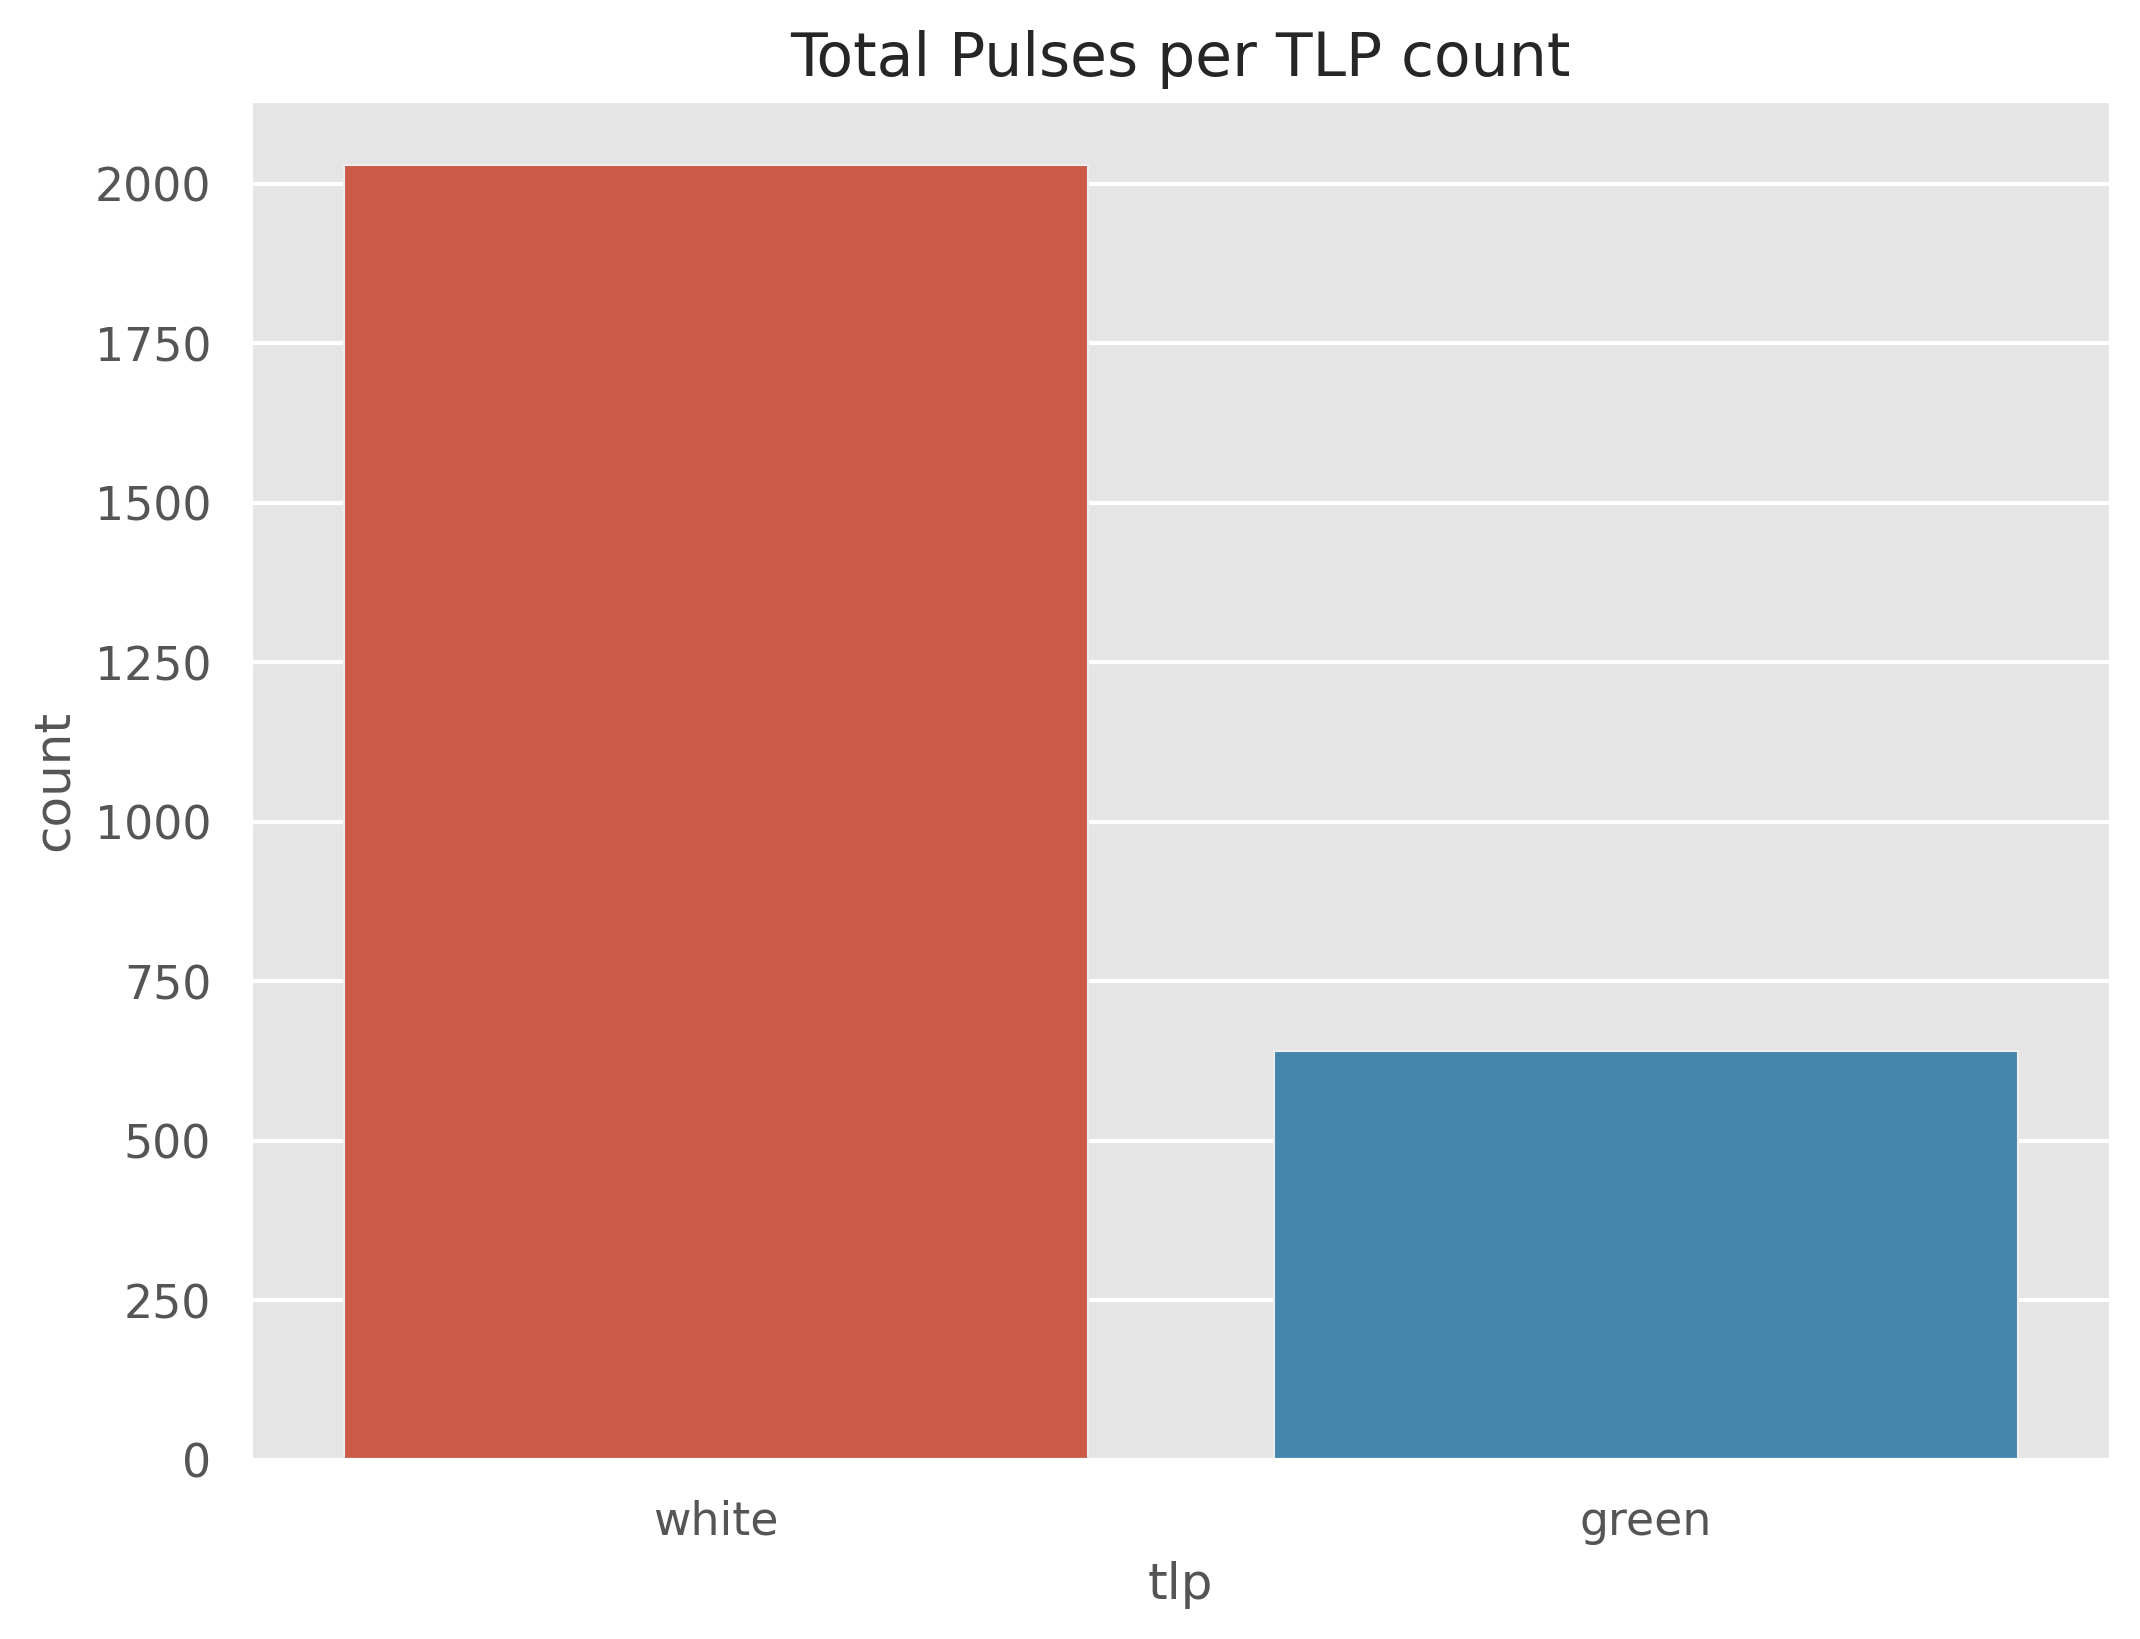

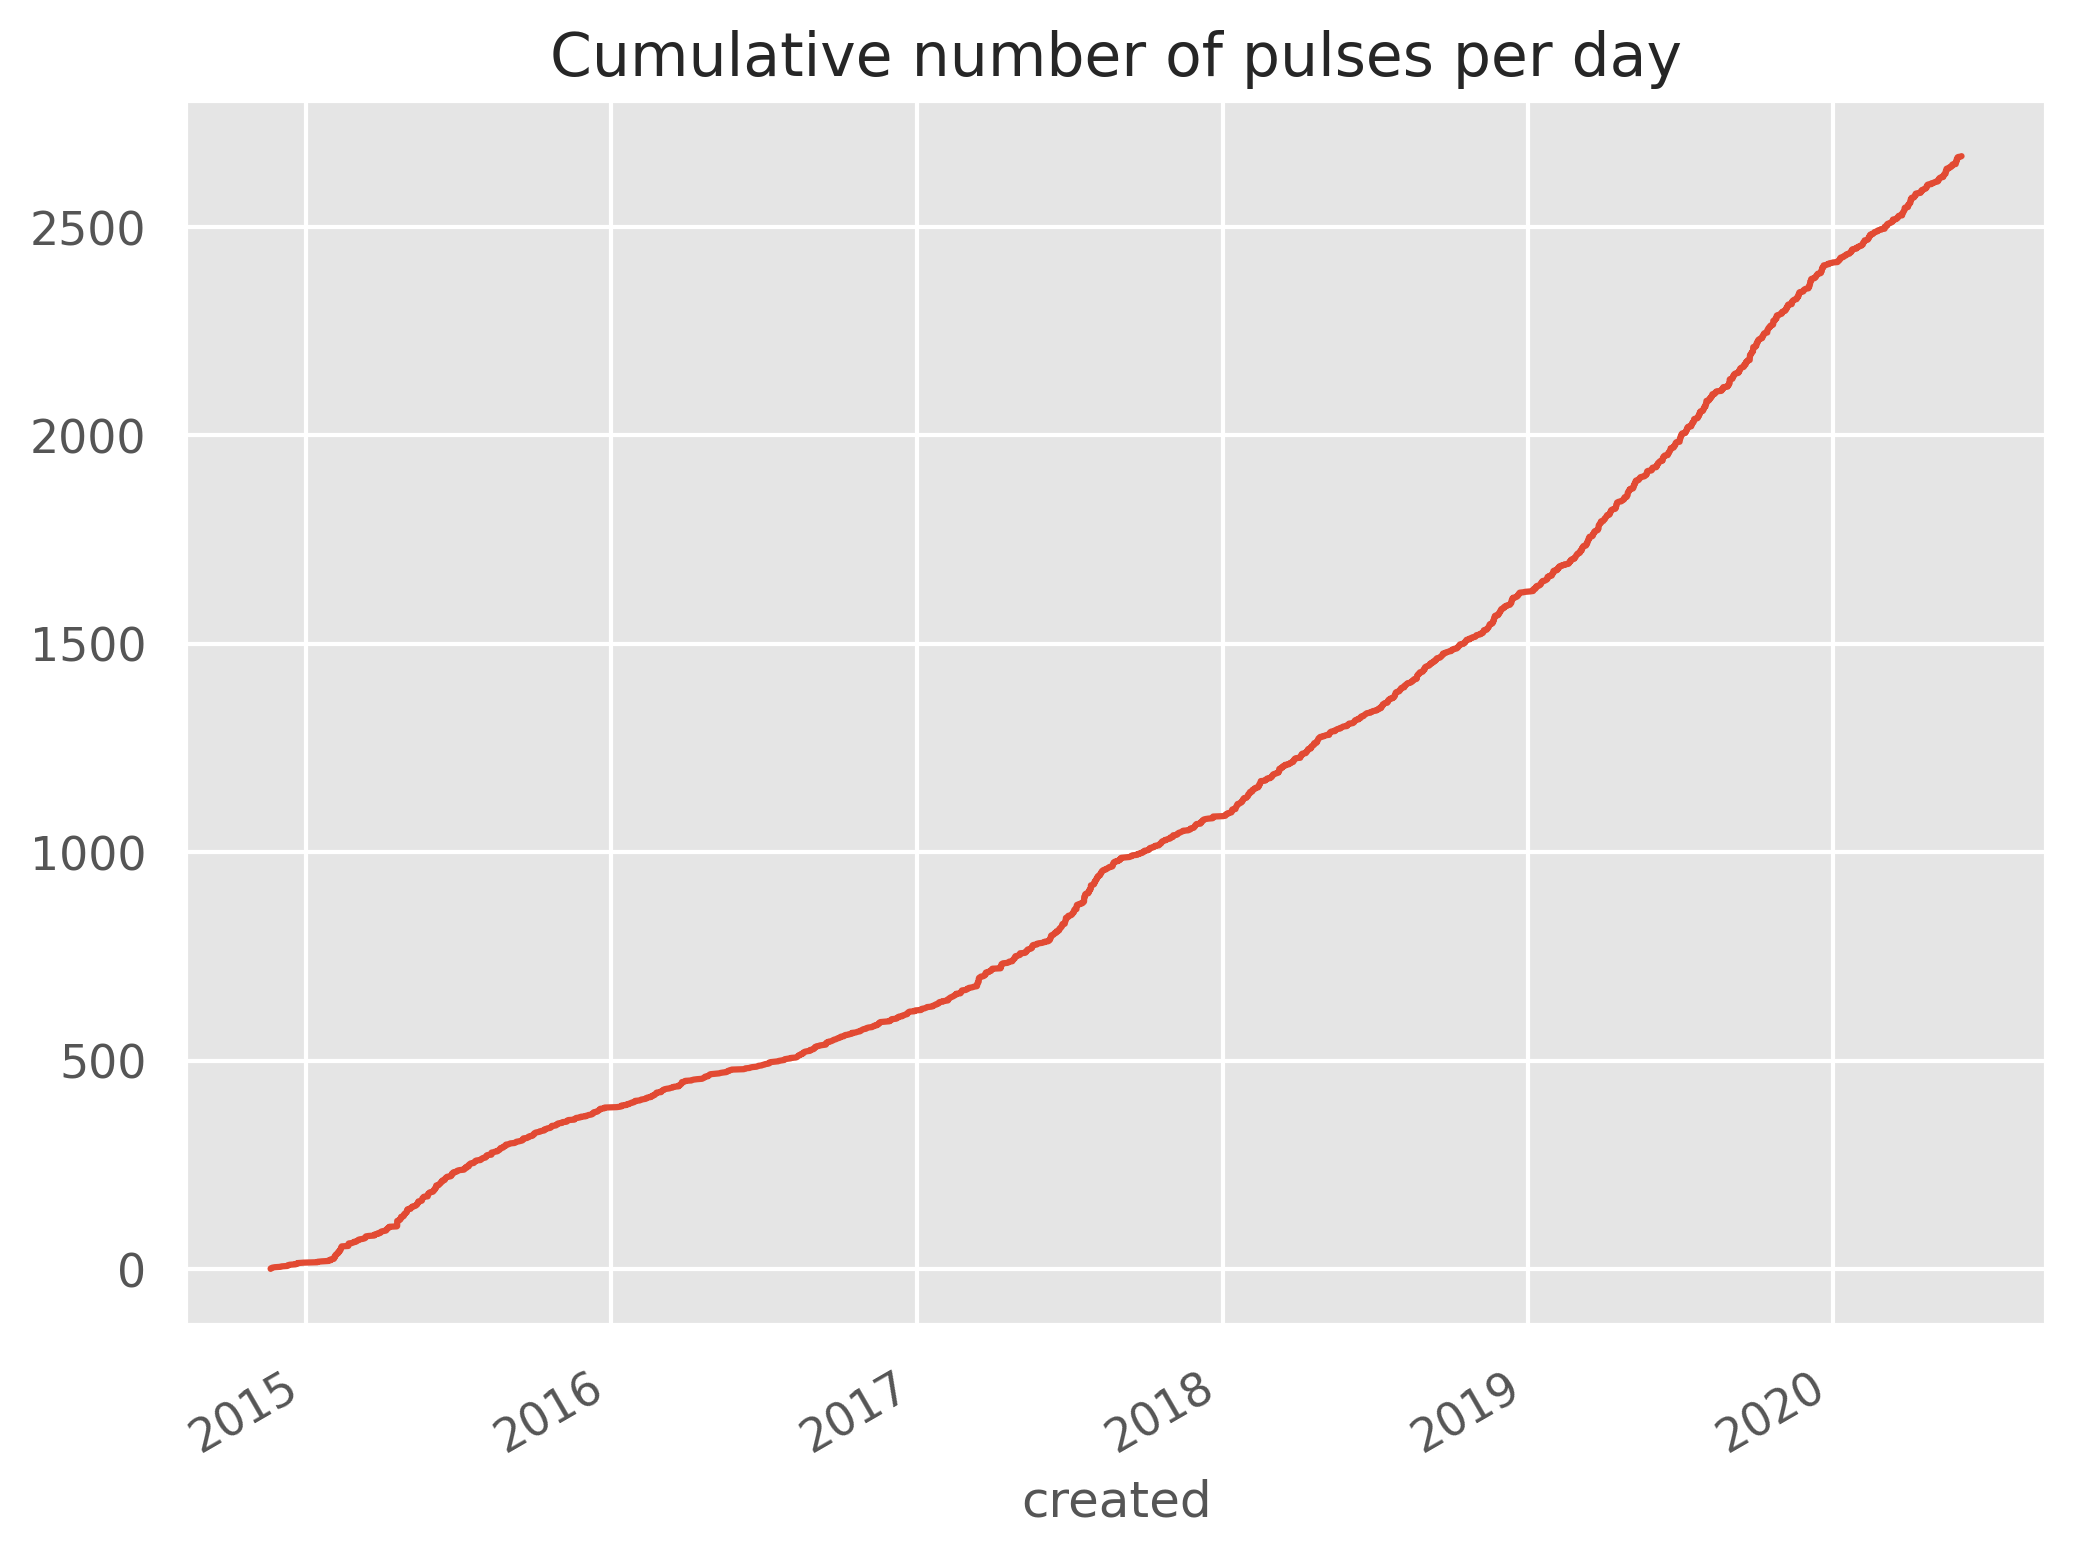

In [216]:
pulses_exploration(pulses_df)

In [ ]:
# Tags

In [166]:
tag_full = []
for i in range(0,pulses_df.shape[0]):
    tag_full.append(pulses_df.iloc[i]['tags'])

res = pd.Series([item for sublist in tag_full for item in sublist]).value_counts()[:10].to_frame()

In [189]:
res.columns=['Number of records']
res = res.sort_values(by = 'Number of records')

<BarContainer object of 10 artists>

Text(0.5, 1.0, 'Most occurred tags')

Text(0.5, 0, 'Count')

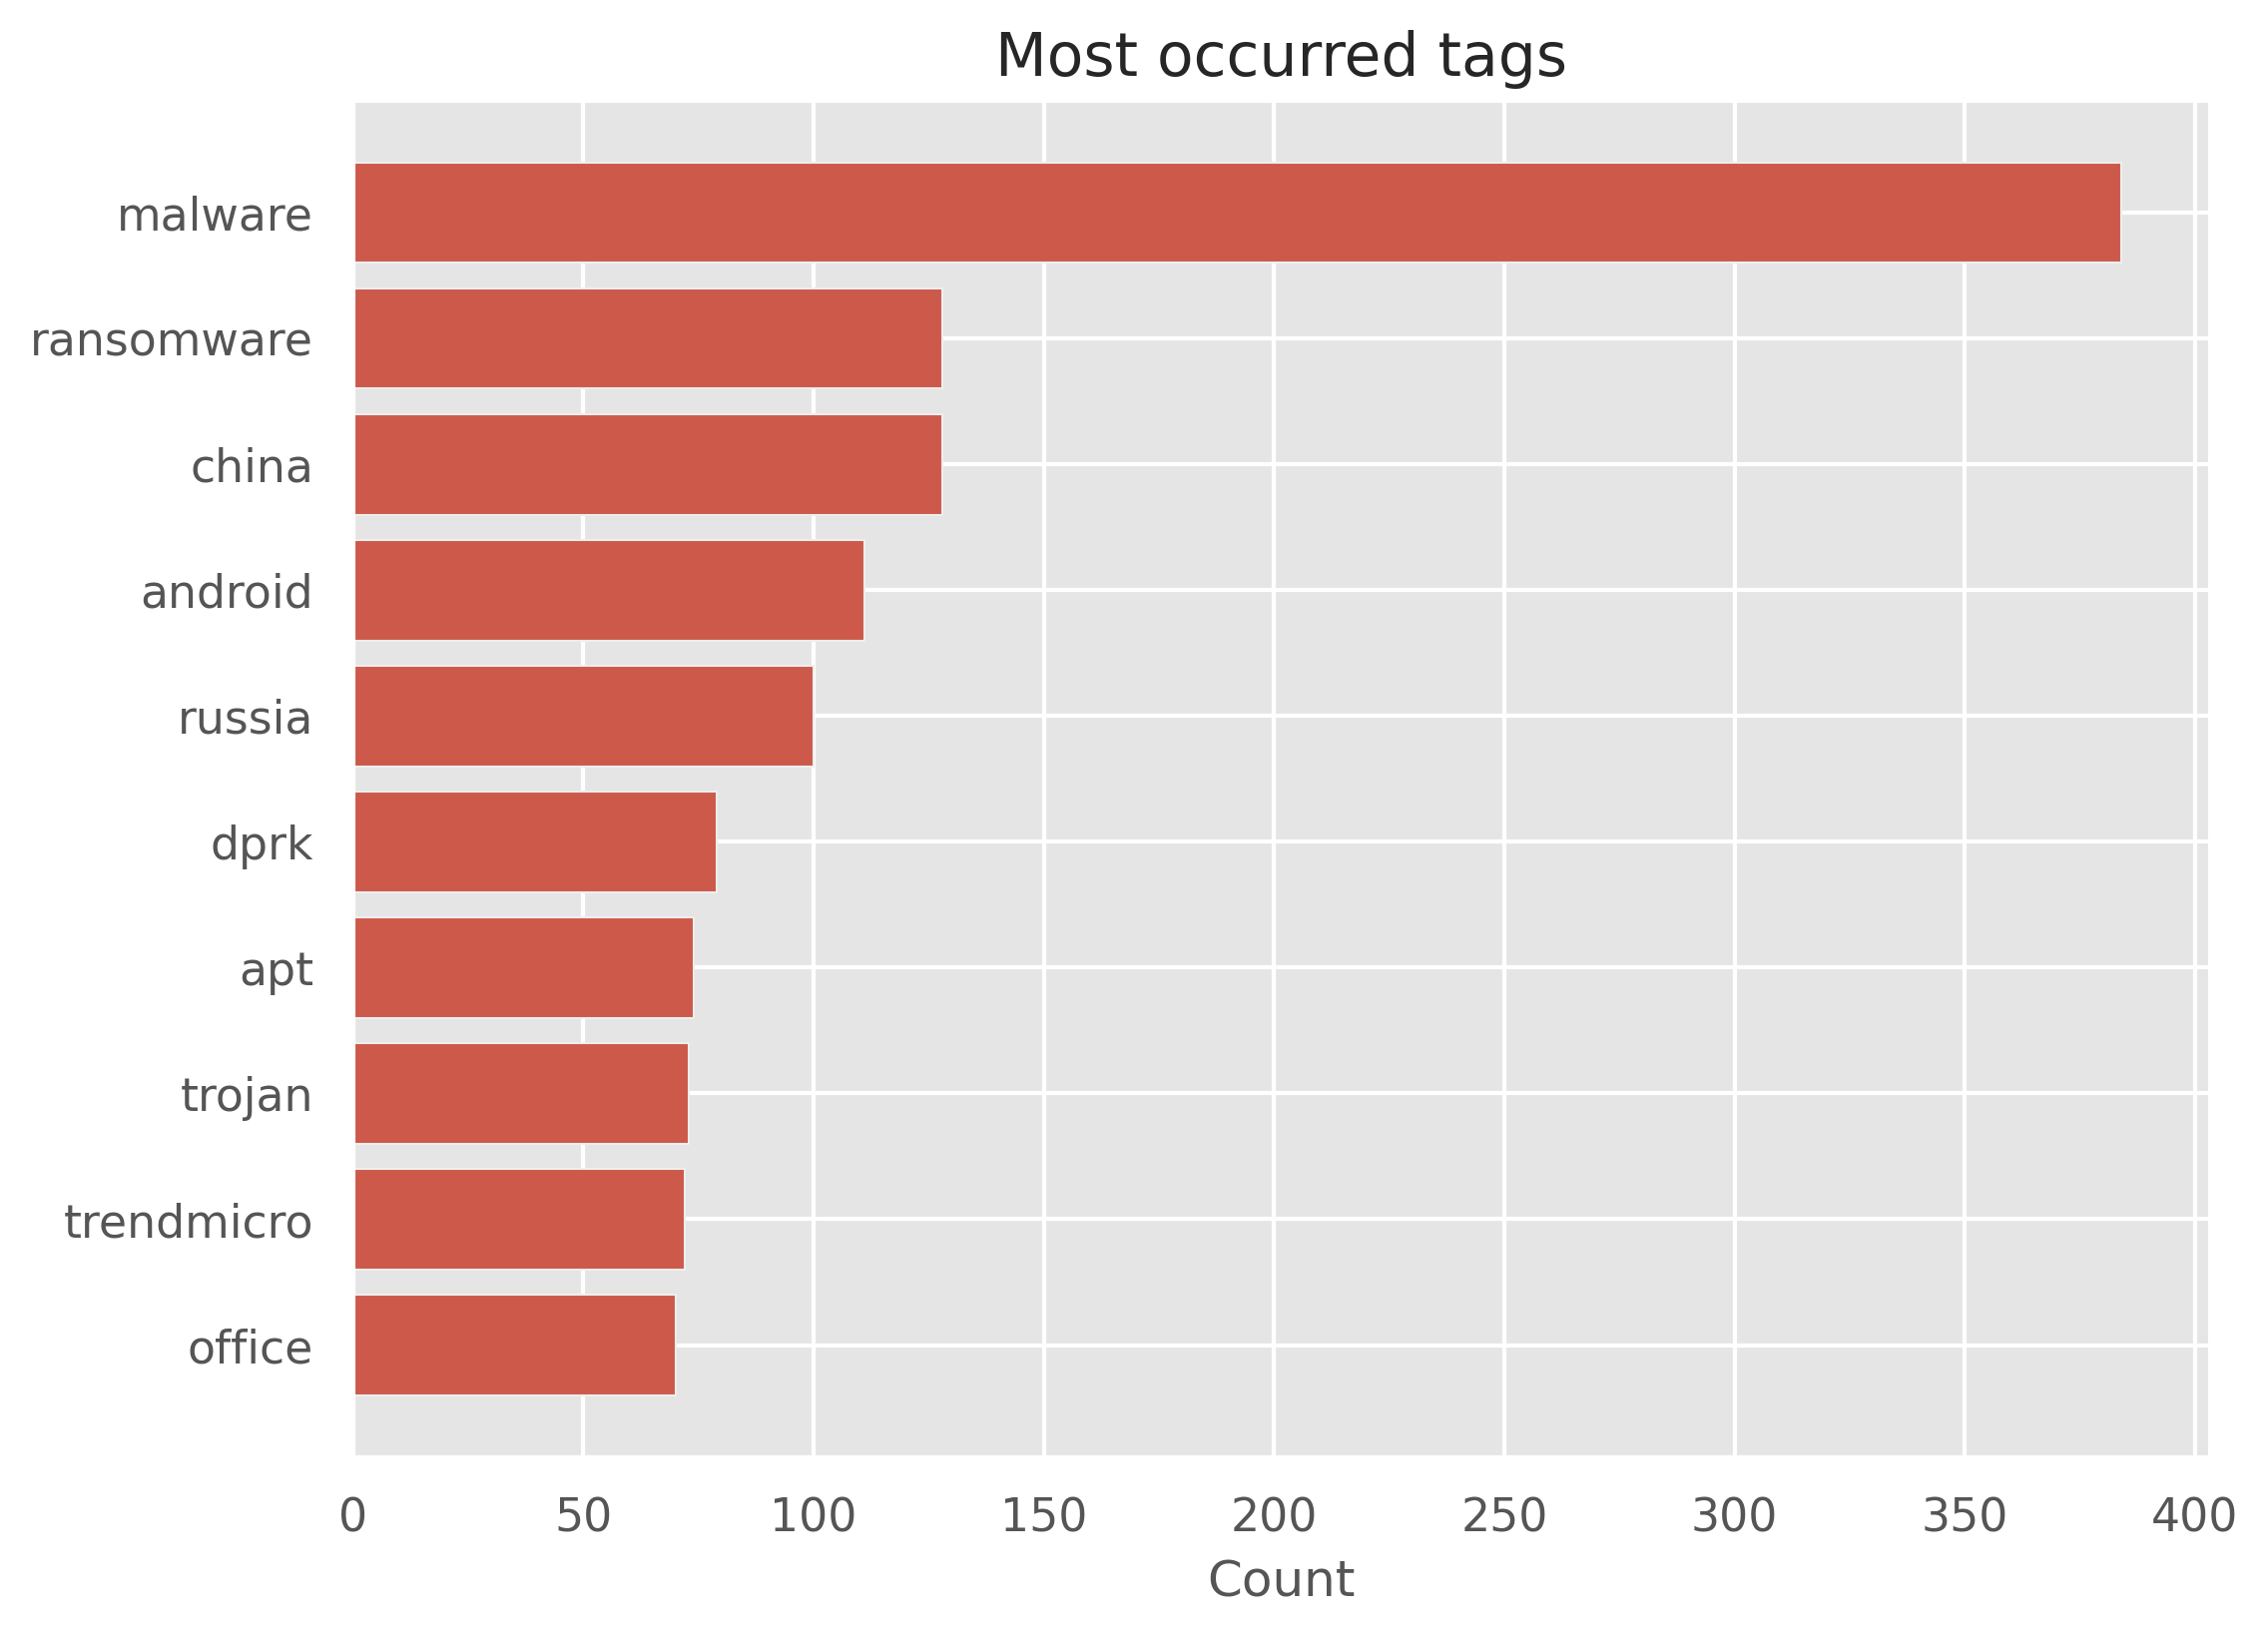

In [238]:
fig, ax = plt.subplots()
ax.barh(res.index, res['Number of records'], color=[(0.8, 0.35, 0.29)])
ax.set_title('Most occurred tags')
ax.set_xlabel('Count')

In [245]:
adv_full

['TA505',
 '',
 '',
 'Turla',
 'Konni',
 'TrickBot Group',
 '',
 '',
 'Sandworm',
 'Aggah',
 'Aggah',
 '',
 '',
 '',
 '',
 'StrongPity',
 'Chafer',
 'Double Guns',
 '',
 'Turla',
 '',
 '',
 '',
 'APT15',
 '',
 '',
 'APT41',
 'Wolf Research',
 '',
 '',
 'MuddyWater',
 '',
 '',
 'TrickBot Group',
 '',
 'Vendetta',
 '',
 '',
 'Turla',
 '',
 'RATicate',
 '',
 'Lazarus Group',
 'Turla',
 'Tropic Trooper',
 'SilverTerrier',
 'Kimsuky',
 'Trickbot',
 'Darkhotel',
 '',
 'Lazarus',
 'OperationHangover',
 '',
 '',
 '',
 '',
 'OceanLotus',
 'Naikon',
 '',
 'Lazarus Group, Hidden Cobra, APT38',
 '',
 '',
 '',
 '',
 '',
 'Nazar',
 '',
 '',
 '',
 '',
 '',
 '',
 'APT41',
 '',
 '',
 'TA505',
 '',
 'Lazarus Group',
 '',
 'APT41',
 '',
 'Chimera',
 '',
 'Evil Eye',
 'Orangeworm',
 'SEA',
 'Dharma',
 '',
 '',
 'Gamaredon Group',
 '',
 '',
 '',
 'FIN7',
 '',
 '',
 '',
 'Kimsuky',
 '',
 'Kimsuky',
 '',
 '',
 'TrickBot Group',
 '',
 '',
 'SideWinder',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 

<BarContainer object of 10 artists>

Text(0.5, 1.0, 'Most occurred tags')

Text(0.5, 0, 'Count')

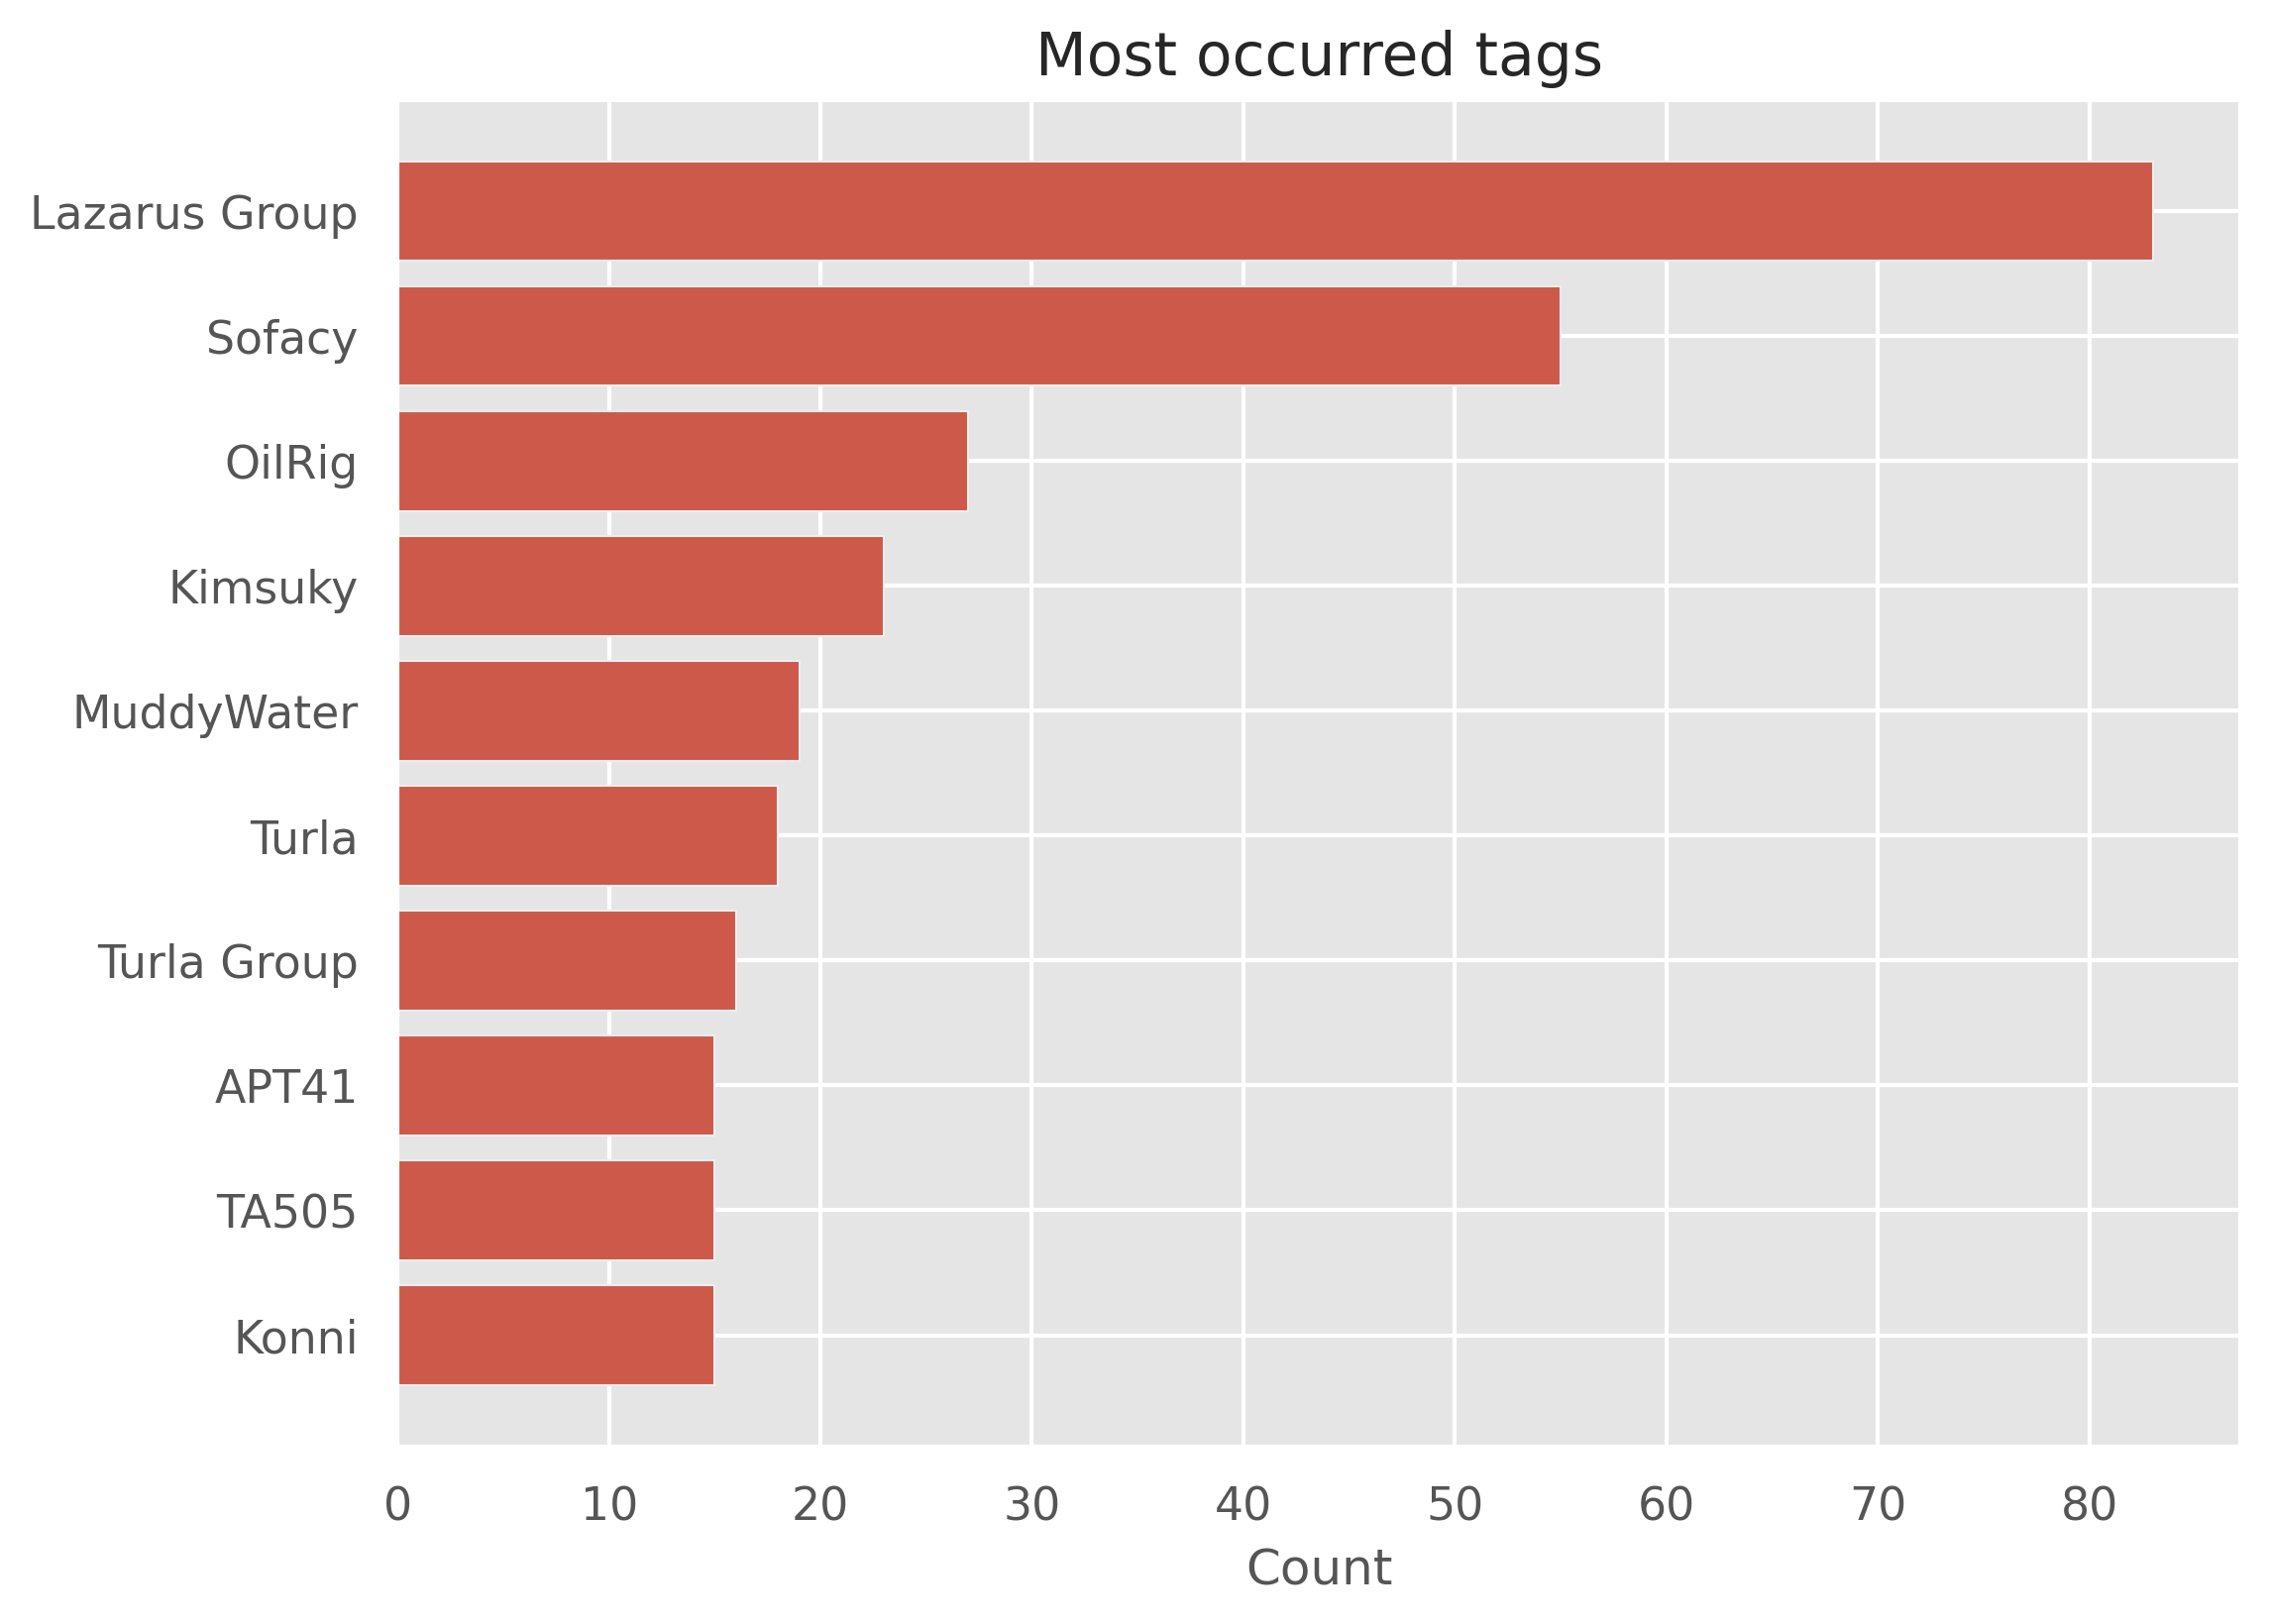

In [248]:
adv_full = []
for i in range(0,pulses_df.shape[0]):
    adv_full.append(pulses_df.iloc[i]['adversary'])

res = pd.Series(adv_full).value_counts()[1:11].to_frame()

res.columns=['Number of records']
res = res.sort_values(by = 'Number of records')

fig, ax = plt.subplots()
ax.barh(res.index, res['Number of records'], color=[(0.8, 0.35, 0.29)])
ax.set_title('Most occurred tags')
ax.set_xlabel('Count')

In [240]:
#Targeted Countries

In [121]:
pd.DataFrame(pulses_df['targeted_countries'].values.tolist()).add_prefix('targeted_countries_')

,targeted_countries_0,targeted_countries_1,targeted_countries_2,targeted_countries_3,targeted_countries_4,targeted_countries_5,targeted_countries_6,targeted_countries_7,targeted_countries_8,targeted_countries_9,targeted_countries_10,targeted_countries_11,targeted_countries_12,targeted_countries_13,targeted_countries_14,targeted_countries_15,targeted_countries_16,targeted_countries_17,targeted_countries_18,targeted_countries_19,targeted_countries_20,targeted_countries_21,targeted_countries_22
0,Germany,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2665,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2666,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2667,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2668,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [122]:
pulses_df['targeted_countries'][2028]
pulses_df['targeted_countries'].to_list()
#pd.DataFrame(pulses_df['targeted_countries'].values.tolist())

from pandas.core.common import flatten
countries = list(flatten(pulses_df['targeted_countries']))
countries_count = pd.Series(countries).value_counts()
countries_count = countries_count.to_frame().reset_index()
countries_count.columns = ['Country', 'Counts']
countries_count

['Spain',
 'Ukraine',
 'United States',
 'Kyrgyzstan',
 'Uzbekistan',
 'Namibia',
 'Zambia',
 'Moldova, Republic of']

[['Germany'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['Italy'],
 [],
 [],
 [],
 [],
 ['Turkey'],
 ['Saudi Arabia', 'Kuwait'],
 [],
 ['Brazil', 'Turkey', 'India', 'Russian Federation', 'Thailand', 'Kazakhstan'],
 [],
 ['Brazil'],
 [],
 ['Taiwan'],
 [],
 [],
 [],
 ['Taiwan', 'Korea, Republic of'],
 [],
 [],
 [],
 ['Belarus', 'Turkey', 'Ukraine'],
 [],
 [],
 [],
 [],
 ['Australia', 'Mexico', 'Egypt', 'Romania', 'Austria'],
 ['Australia',
  'United States',
  'Canada',
  'Germany',
  'France',
  'Italy',
  'Netherlands',
  'Poland',
  'Spain',
  'Singapore',
  'United Kingdom'],
 ['Germany'],
 [],
 [],
 [],
 ['Russian Federation', 'Belarus', 'Mongolia'],
 ['United Kingdom', 'United States'],
 [],
 ['Taiwan', 'Philippines'],
 ['Indonesia',
  'United States',
  'Italy',
  'Australia',
  'Canada',
  'United Kingdom'],
 [],
 [],
 [],
 [],
 ['United States'],
 ['Pakistan', 'Maldives', 'Bangladesh'],
 ['United States', 'China', 'Germany'],
 [],
 ['Brazil'],
 [],
 ['United States',
  'Japa

,Country,Counts
0,United States,104
1,"Korea, Republic of",83
2,Ukraine,51
3,Japan,50
4,Turkey,47
...,...,...
114,Slovenia,1
115,Cameroon,1
116,Slovakia,1
117,Nepal,1


In [239]:
countries_count

,Country,Counts
0,United States,104
1,"Korea, Republic of",83
2,Ukraine,51
3,Japan,50
4,Turkey,47
...,...,...
114,Slovenia,1
115,Cameroon,1
116,Slovakia,1
117,Nepal,1


In [124]:
import plotly.express as px

fig = px.choropleth(countries_count, locations="Country",
                    color="Counts", # lifeExp is a column of gapminder
                    hover_name="Country", # column to add to hover information
                    locationmode = 'country names',
                    color_continuous_scale="Reds"
                   )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

## Explore Indicators of Compromise of each pulse

Indicators of Compromise (IoCs) serve as forensic evidence of potential intrusions on a host system or network. These artifacts enable information security (InfoSec) professionals and system administrators to detect intrusion attempts or other malicious activities. Security researchers use IoCs to better analyze **a particular malware’s techniques and behaviors.** IoCs also provides actionable threat intelligence that can be shared within the community to further improve an organization’s incident response and remediation strategies.

Some of these artifacts are found on event logs and timestamped entries in the system, as well as on its applications and services. InfoSec professionals and IT/system administrators also employ various tools that monitor IoCs to help mitigate, if not prevent, breaches or attacks. 

Source: Trendmicro; a more thorough article (description, infographics, resources) of IoCs can be found here: https://www.trendmicro.com/vinfo/us/security/definition/indicators-of-compromise

Below we show the IoCs of our first pulse:


In [ ]:
pd.json_normalize(pulses_df['indicators'][0])

### Explanation of IoCs Attributes

> Description of the attributes is a mix of documentantion and personal research (labelled as [P], if no information then empty)

- description: Describe the Indicator Of Compromise
- title [P]:  
- created: Date IOC was added to the pulse
- is_active [P]:  
- content [P]: 
- expiration [P]:
- type: Type of indicator
- id: Unique identifier of the IOC



### Attributes - Summary Statistics of IoCs
Below we define a function which show attributes or calculate/visualize summary statistics out of indicators. The function uses the indicators of a given pulse. If the optional argument full=True then all the indicators out of all Pulses are considered.

In [249]:
pulses_df.iloc[86]

industries                                                           []
tlp                                                               white
description           The Dharma ransomware has been around since 20...
created                                      2019-05-08 13:15:41.605000
tags                                                       [ransomware]
malware_families                                                     []
modified                                     2020-04-20 16:36:33.455000
author_name                                                  AlienVault
public                                                                1
extract_source                                                       []
references            [https://blog.trendmicro.com/trendlabs-securit...
targeted_countries                                                   []
indicators                                                           []
attack_ids                                                      

In [250]:
#pd.json_normalize(pulses_df['indicators'][86])

In [251]:
pulses_df.shape[0]

2670

In [259]:
from IPython.core import display as ICD #ref: https://stackoverflow.com/a/36721331/13030358
import json

def explore_iocs(pulses_DF, **kwargs):
    if 'full' in kwargs:
        if kwargs.get("full")==True:
            
            full_iocs = pd.DataFrame(columns=['indicator', 'description', 'title', 'created', 'is_active', 'content',
           'expiration', 'type', 'id', 'pulse_name', 'pulse_id'])

            for uid in range(0, pulses_df.shape[0]):
                uid_pulses = pulses_df['indicators'][uid]
                uid_pulses = pd.json_normalize(uid_pulses)
                uid_pulses['pulse_name'] = pulses_df['name'][uid]
                uid_pulses['pulse_id'] = pulses_df['id'][uid]
                full_iocs = full_iocs.append(uid_pulses)
            
            iocs = full_iocs
            print('Total Number of unique indicators per pulse:')
            pulse_iocs_count = iocs.groupby(['pulse_name', 'pulse_id'])['id'].count().to_frame()
            pulse_iocs_count = pulse_iocs_count.sort_values('id', ascending=False)
            pulse_iocs_count.columns = ['Number of IoC(s)']
            ICD.display(pulse_iocs_count)
            
        else:
            single_pulse_DF = pulses_DF.loc[pulses_DF.id==kwargs.get("pulse_id")]
            iocs = pd.json_normalize(list(single_pulse_DF['indicators'].values)[0])
            print('Pulse Name:', single_pulse_DF['name'].values[0])
    else:
        single_pulse_DF = pulses_DF.loc[pulses_DF.id==kwargs.get("pulse_id")]
        iocs = pd.json_normalize(list(single_pulse_DF['indicators'].values)[0])
        print('Pulse Name:', single_pulse_DF['name'].values[0])

    
    print('Fraction of Null to total per attribute:')
    missing = pd.Series(iocs.isnull().mean() * 100).to_frame().round(2).T
    missing.index = ['Missing (%):']
    ICD.display(missing)
    
    
    #total unique IoCs
    print('Total Number of unique indicators: ',  iocs['indicator'].nunique())
    iocs.shape 

    #description
    print('Descriptions of IoCs (if any):')
    ioc_descrpt = iocs['description'].replace('', np.nan).dropna().to_frame()
    pd.set_option('max_colwidth', None) #temporary show full text - open
    if not ioc_descrpt.empty:
        ICD.display(ioc_descrpt)
    pd.set_option('max_colwidth', 50) #temporary show full text - close
    ioc_title = iocs['title'].replace('', np.nan).dropna().to_frame()

    #title
    pd.set_option('max_colwidth', None) #temporary show full text - open
    if not ioc_title.empty:
        ICD.display(ioc_title)
    pd.set_option('max_colwidth', 50) #temporary show full text - close

    #created
    iocs.created = pd.to_datetime(iocs.created) #convert to datetime
    
    #active IoCs
    print('There is/are', iocs.is_active.value_counts()[1] ,"active IoC(s), out of", iocs.shape[0] ,"IoC(s)" )

    print('Date of First IoC: ', iocs.created.min())
    print('Date of Last IoC: ', iocs.created.max())
    if iocs.created.min() != iocs.created.max(): #cumulative graph of iocs per day (if we have between different periods)
        #cumulative number of iocs per day
        temp_iocs_created = iocs.groupby('created').indicator.count()
        temp_iocs_created = temp_iocs_created.groupby(temp_iocs_created.index).cumsum().reset_index()
        temp_iocs_created['cumsum_iocs'] = temp_iocs_created.indicator.cumsum()
        temp_iocs_created = temp_iocs_created.set_index('created')
        temp_iocs_created.index = temp_iocs_created.index.astype(str)        
        temp_iocs_created.cumsum_iocs.plot(title='Cumulative IoCs per timestamp', rot=90)
        plt.subplots() 

    #type
    iocs['type'].value_counts().sort_values(ascending=True).plot(kind="barh", ax=plt.gca(), title='Number of IoCs per type', ylabel='Count')
    

Below we display attributes and summary statistics from all pulses:

Total Number of unique indicators per pulse:


,,Number of IoC(s)
pulse_name,pulse_id,
The Gopher in the Room: Analysis of GoLang Malware in the Wild,5d1a54719286307ea32e3f5e,10703
Hashes from Territorial Dispute,5aa25498cb896448aefe2f07,5197
SquirtDanger: The Swiss Army Knife Malware from Veteran Malware Author TheBottle,5ad764965c80937a45e917d9,3995
Abusing Code Signing for Profit,5ce56590c20268fb2c8150d0,3815
Astaroth - Analysis Reveals Dark Stealer,5eb9776da9f82b6e9a5d1036,3375
...,...,...
"Linux Mint website hacked, ISO backdoored",56ca196567db8c585fd20e58,1
XFSCashNCR ATM Skimming Malware,5d68f923fb88ee840325bcf0,1
Finding Hackingteam code in Russian malware,58ada215127e5a3295e35eca,1


Fraction of Null to total per attribute:


,indicator,description,title,created,is_active,content,expiration,type,id,pulse_name,pulse_id
Missing (%):,0.0,0.02,0.02,0.0,0.0,0.11,99.91,0.0,0.0,0.0,0.0


Total Number of unique indicators:  155955
Descriptions of IoCs (if any):


,description
6,SHA256 of b34b74effbd8647c4f5dc61358e1555f
23,SHA1 of b34b74effbd8647c4f5dc61358e1555f
0,SHA256 of 97fa1f66bd2b2f8a34aafe5a374996f8
2,SHA1 of 97fa1f66bd2b2f8a34aafe5a374996f8
4,SHA256 of 4620c79333ce19e62efd2adc5173b99a
...,...
9,"Red Leaves malware, related to APT10"
4,BernhardPOS Credit Card dumping tool
0,IP addresses associated with URL injected into Telnet honeypot
1,Downloaded file: minerd


,title
6,Other:Malware-gen\ [Trj]
20,Other:Malware-gen\ [Trj]
23,Other:Malware-gen\ [Trj]
0,#Exploit:Win32/CVE-2014-6352.A!lofi
1,#Exploit:Win32/CVE-2014-6352.A!lofi
...,...
203,crime_ZZ_EyePyramid
265,VBPacker_FareIT_Zbot
266,MSILPacker_FareIT_ISR_Stealer_Luminosity_HawkEye
9,malware_red_leaves_generic


There is/are 166515 active IoC(s), out of 166515 IoC(s)
Date of First IoC:  2014-12-02 16:26:17
Date of Last IoC:  2020-06-02 16:59:16


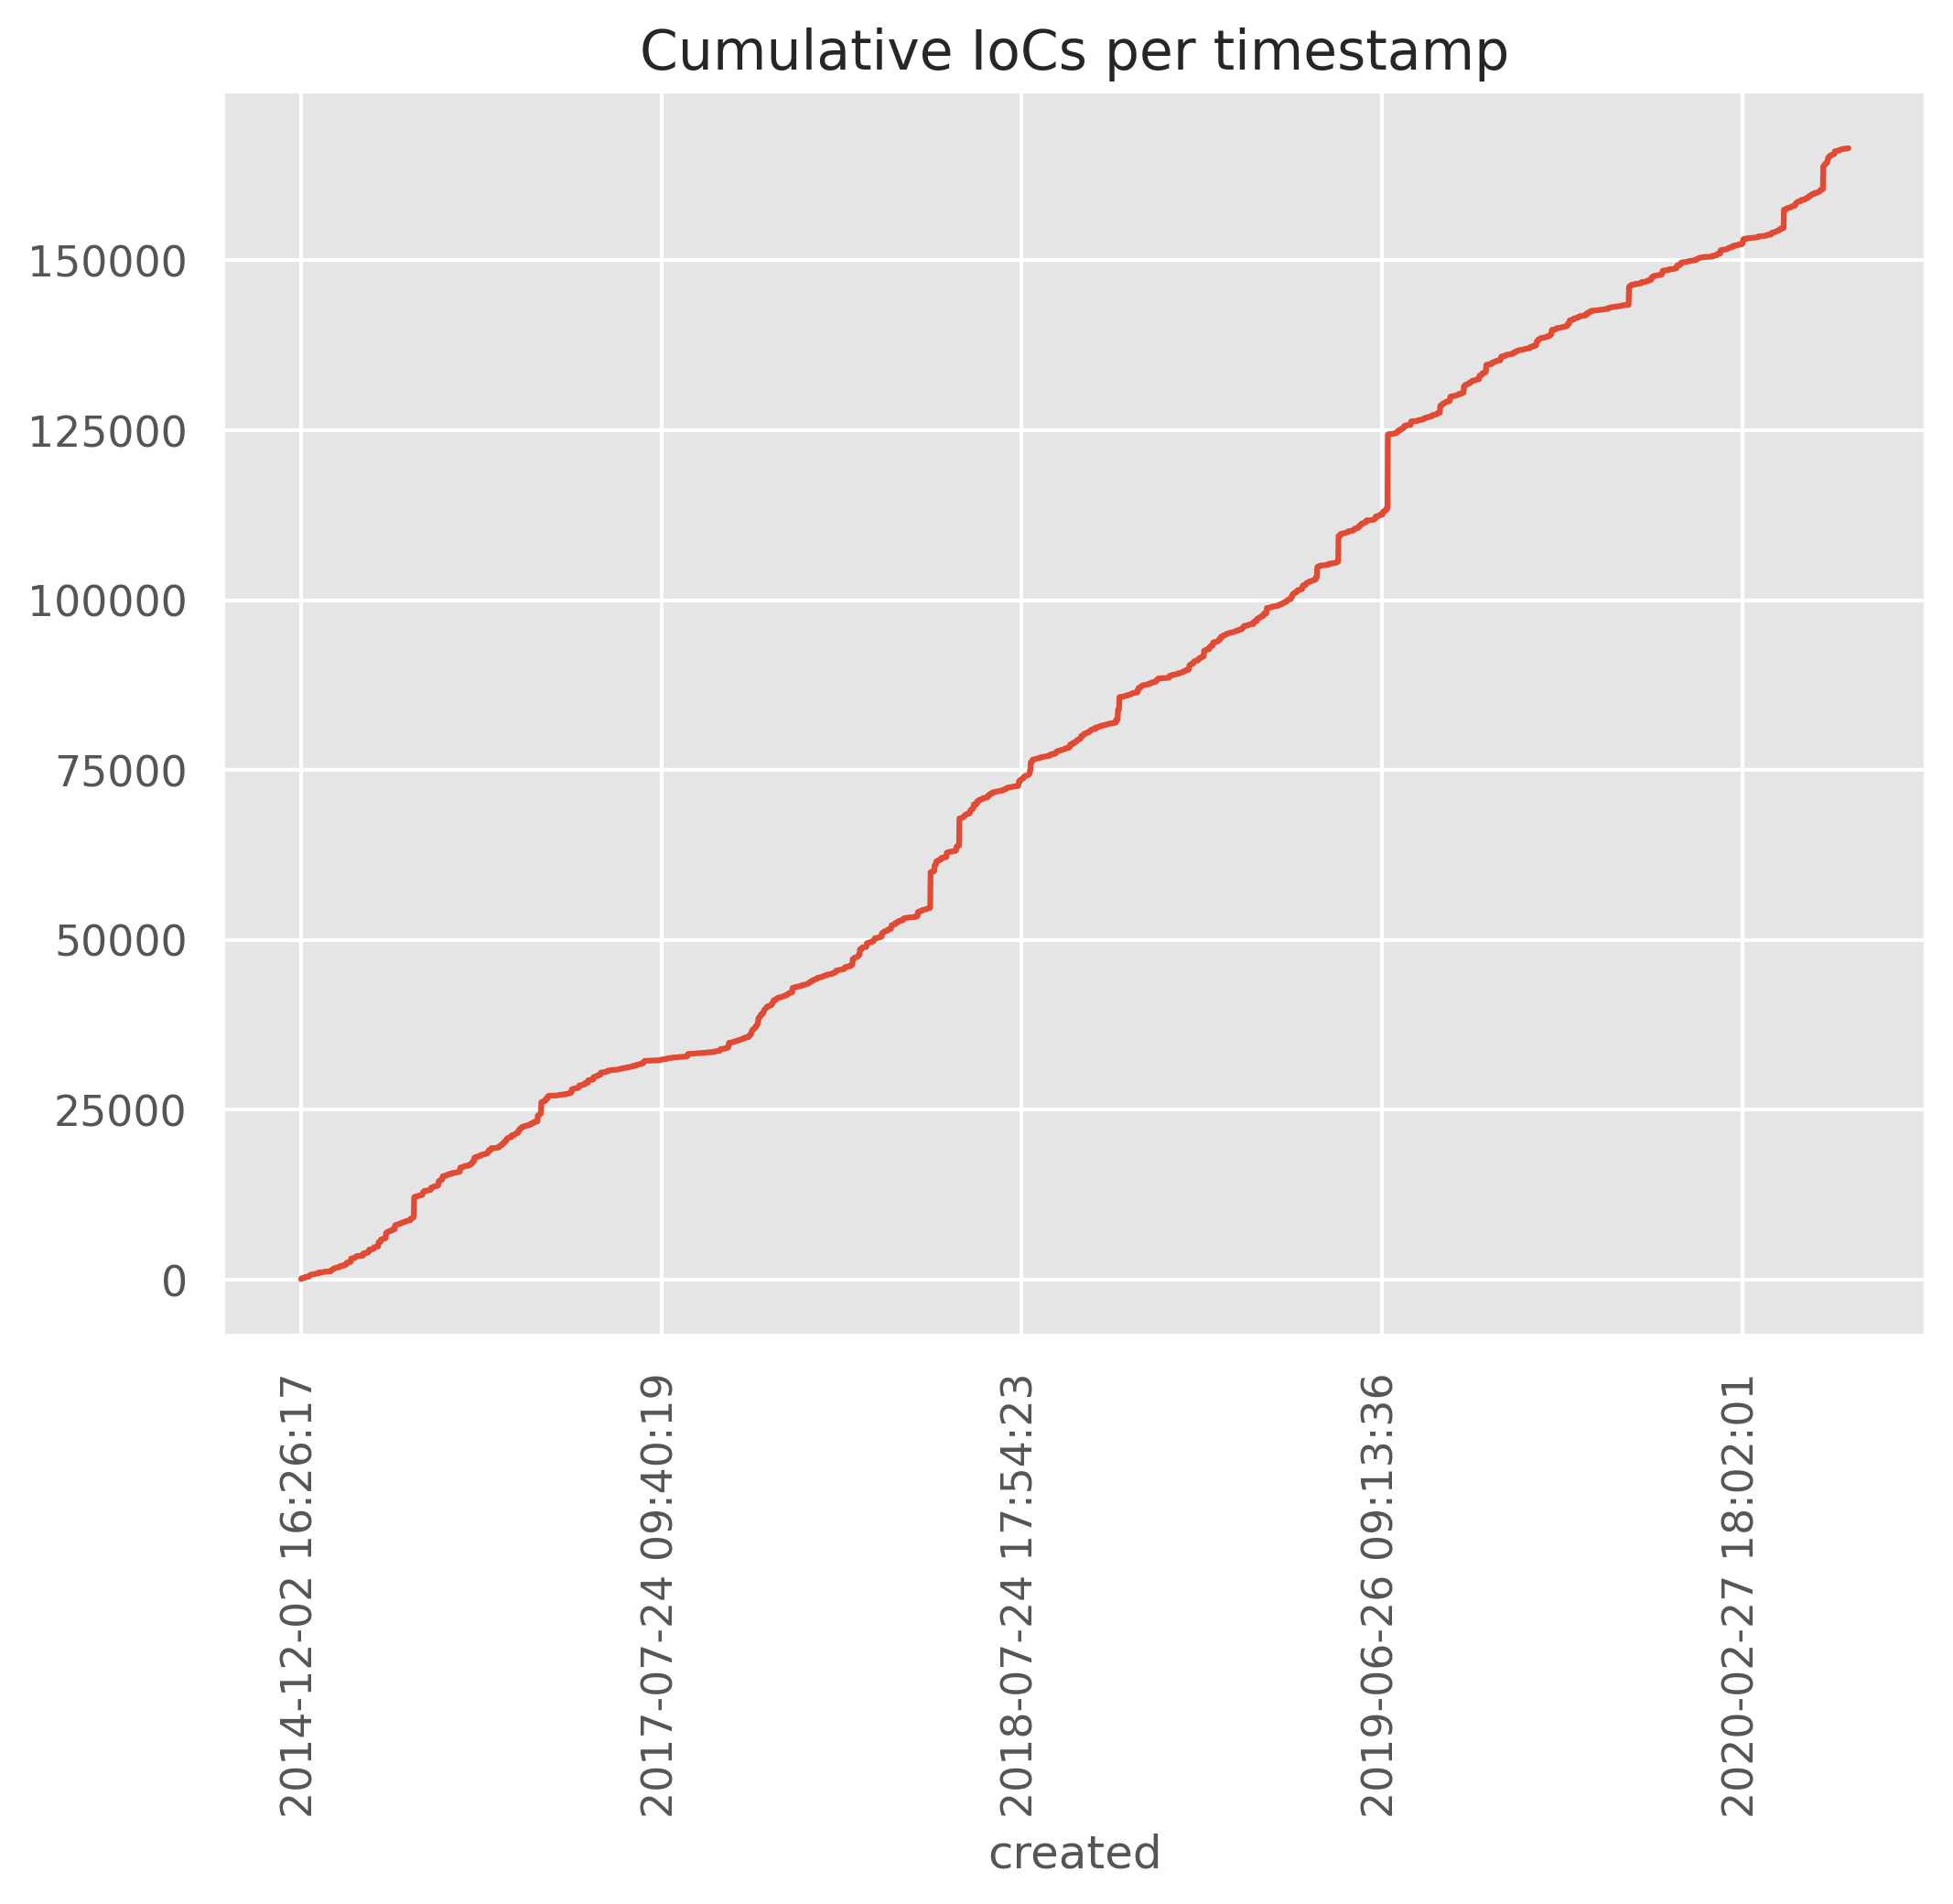

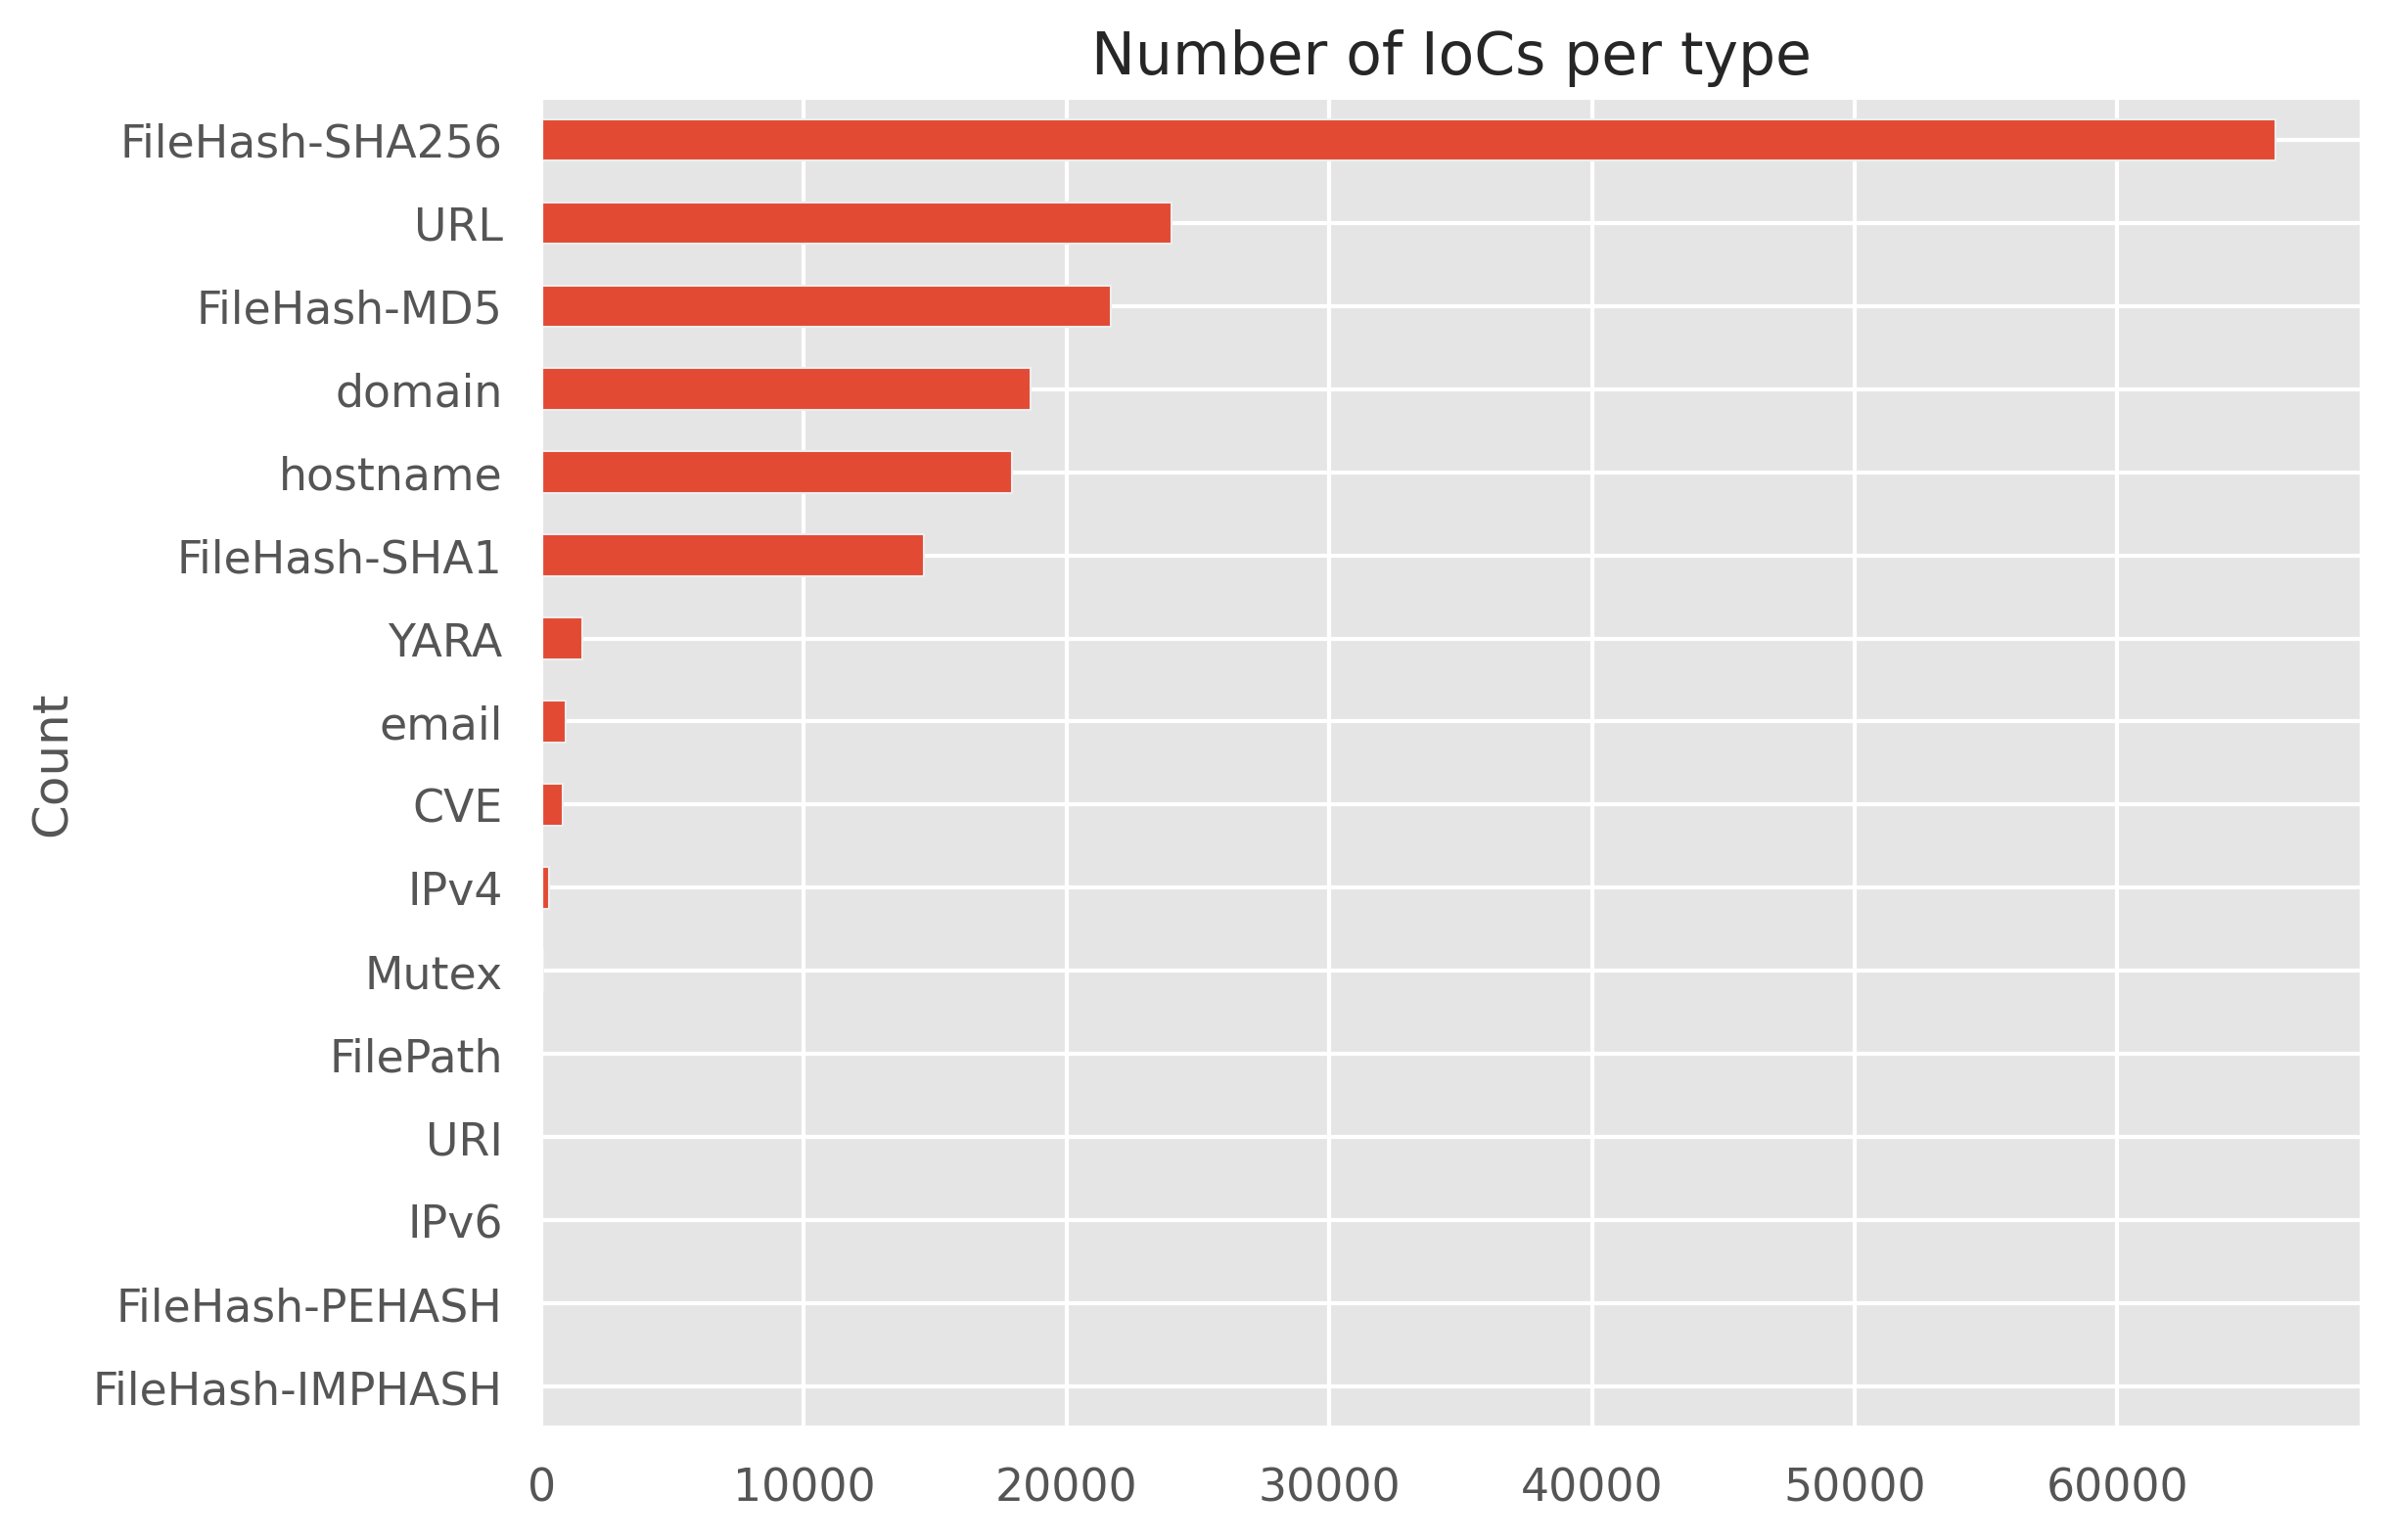

In [260]:
explore_iocs(pulses_df, full=True)

Below we display attributes and summary statistics from the first pulse:

In [ ]:
explore_iocs(pulses_df, pulse_id='5d1a54719286307ea32e3f5e')

## Ideas for next steps:

 - Extract information from IP addresses in indicators; use IPWHOIS.io (quota 10000 queries/month - maybe use it in the final pulse collection) (ref: https://rapidapi.com/xakageminato/api/ip-geolocation-ipwhois-io/pricing) 

 - Extract information for indicators from external resources. By checking the page of a single indicator (e.g. https://otx.alienvault.com/indicator/file/e470a85d592ef4a8941731aea4543163cb249675) we find a direct link to VirusTotal.com site. We may extract more attributes from that site (we found an API) or other relevant virus directory sites.
 
 - Find more information for the attributes of pulses and indicators.
 
 - Investigate further for the different pulse_ids of the same pulse. Decide if they can be considered as duplicate

 - Investigate attributes which were constant in this analysis: In our experiment of the 41 pulses many attributes of the pulses and indicators had the same value across all records. When we define our final pulse collection we may need to check them again



In [261]:
full_iocs_export = pd.DataFrame(columns=['indicator', 'description', 'title', 'created', 'is_active', 'content',
           'expiration', 'type', 'id', 'pulse_name', 'pulse_id'])

for uid in range(0, pulses_df.shape[0]):
    uid_pulses = pulses_df['indicators'][uid]
    uid_pulses = pd.json_normalize(uid_pulses)
    uid_pulses['pulse_name'] = pulses_df['name'][uid]
    uid_pulses['pulse_id'] = pulses_df['id'][uid]
    full_iocs_export = full_iocs_export.append(uid_pulses)
    
#full_iocs_export.to_csv('./fetched_data/full_iocs_set_v2.csv')  

In [ ]:
#full_iocs_export.loc[full_iocs_export.type=='domain']